[リンクテキスト](https://)

In [1]:
!pip install numpy==1.23.5

In [2]:
# Colab上では以下を実行してください
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt-get install xvfb
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install JSAnimation
!pip install xvfbwrapper

# Colab上では以下を実行してください
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(400, 300))
pydisplay.start()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [3]:
import numpy as np
import copy
from collections import deque
import gym
from gym import wrappers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from IPython import display
from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

In [4]:
env = gym.make('CartPole-v1')  # シミュレータ環境の構築
frames = []
for episode in range(5):
    state = env.reset()  # エピソードを開始（環境の初期化）
    env.render()  # シミュレータ画面の出力
    screen = env.render(mode='rgb_array')  # notebook上での結果の可視化用
    frames.append(screen)
    done = False
    while not done:
        action = env.action_space.sample()  # 行動をランダムに選択
        next_state, reward, done, _ = env.step(action)  # 行動を実行し，次の状態， 報酬， 終端か否かの情報を取得
        env.render()
        screen = env.render(mode='rgb_array')
        frames.append(screen)
env.close()  # 画面出力の終了

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

In [5]:
# Random state
env = gym.make('CartPole-v1')
state = env.reset()
frames = []

for episode in range(5):
  state = env.reset()
  env.render()
  screen = env.render(mode='rgb_array')
  frames.append(screen)
  done = False
  while not done:
    action = np.random.choice([0, 1]) #
    next_state, reward, done, info = env.step(action) #
    env.render() #
    screen = env.render(mode='rgb_array')
    frames.append(screen)
env.close()

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = torch.tensor(np.stack([x[0] for x in data]))
        action = torch.tensor(np.array([x[1] for x in data]).astype(np.long))
        reward = torch.tensor(np.array([x[2] for x in data]).astype(np.float32))
        next_state = torch.tensor(np.stack([x[3] for x in data]))
        done = torch.tensor(np.array([x[4] for x in data]).astype(np.int32))
        return state, action, reward, next_state, done

In [7]:
env = gym.make('CartPole-v0')
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)
for episode in range(10):
  state = env.reset()
  done = False
  while not done:
    action = 0
    next_state, reward, done, info = env.step(action)
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state

state, action, reward, next_state, done = replay_buffer.get_batch()
print(state.shape) # (32, 4)
print(action.shape) # (32,)
print(reward.shape) # (32,)
print(next_state.shape) # (32, 4)
print(done.shape) # (32,)

torch.Size([32, 4])
torch.Size([32])
torch.Size([32])
torch.Size([32, 4])
torch.Size([32])


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
<ipython-input-6-992ea855edd8>:21: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  action = torch.tensor(np.array([x[1] for x in data]).astype(np.long))


In [8]:
class QNet(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=self.lr)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.tensor(state[np.newaxis, :])
            qs = self.qnet(state)
            return qs.argmax().item()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        qs = self.qnet(state)
        q = qs[np.arange(len(action)), action]

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(1)[0]

        next_q.detach()
        target = reward + (1 - done) * self.gamma * next_q

        loss_fn = nn.MSELoss()
        loss = loss_fn(q, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sync_qnet(self):
        self.qnet_target.load_state_dict(self.qnet.state_dict())

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-39-992ea855edd8>:21: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wi

Episode: 0, Reward: 10.0
Episode: 10, Reward: 9.0
Episode: 20, Reward: 16.0
Episode: 30, Reward: 8.0
Episode: 40, Reward: 8.0
Episode: 50, Reward: 10.0
Episode: 60, Reward: 13.0
Episode: 70, Reward: 9.0
Episode: 80, Reward: 8.0
Episode: 90, Reward: 9.0
Episode: 100, Reward: 10.0
Episode: 110, Reward: 9.0
Episode: 120, Reward: 13.0
Episode: 130, Reward: 12.0
Episode: 140, Reward: 11.0
Episode: 150, Reward: 24.0
Episode: 160, Reward: 13.0
Episode: 170, Reward: 13.0
Episode: 180, Reward: 44.0
Episode: 190, Reward: 14.0
Episode: 200, Reward: 13.0
Episode: 210, Reward: 65.0
Episode: 220, Reward: 85.0
Episode: 230, Reward: 227.0
Episode: 240, Reward: 251.0
Episode: 250, Reward: 16.0
Episode: 260, Reward: 267.0
Episode: 270, Reward: 255.0
Episode: 280, Reward: 285.0
Episode: 290, Reward: 250.0


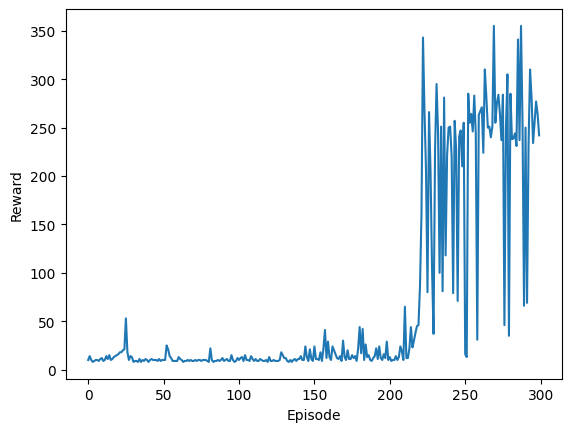

In [ ]:
from math import e
episodes = 300
synv_interval = 50
env = gym.make('CartPole-v1')
agent = DQNAgent()
reward_history = []

for episode in range(episodes):
  state = env.reset()
  done = False
  total_reward = 0
  while not done:
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    agent.update(state, action, reward, next_state, done)
    state = next_state
    total_reward += reward
  if episode % synv_interval == 0:
    agent.sync_qnet()
  reward_history.append(total_reward)
  if episode % 10 == 0:
    print(f'Episode: {episode}, Reward: {total_reward}')

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
frames = []
agent.epsilon = 0 # greedy policy
state = env.reset()
done = False
total_reward = 0
env.render()
screen = env.render(mode='rgb_array')
frames.append(screen)

while not done:
  action = agent.get_action(state) #
  next_state, reward, done, info = env.step(action) #
  state = next_state
  total_reward += reward
  env.render() #
  screen = env.render(mode='rgb_array')
  frames.append(screen)

env.close()
print('Total Reward:', total_reward)

/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Reward: 241.0


# 結果確認セル

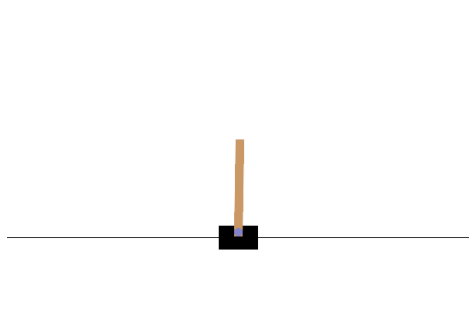

In [ ]:
# 結果の確認
plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())

In [9]:
class Policy(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x), dim=1)
        return x


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.lr)

    def get_action(self, state):
        state = torch.tensor(state[np.newaxis, :])
        probs = self.pi(state)
        probs = probs[0]
        m = Categorical(probs)
        action = m.sample().item()
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G

        for reward, prob in self.memory:
            loss += - torch.log(prob) * G

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.memory = []

In [ ]:
env = gym.make('CartPole-v1')
agent = Agent()
reward_history = []

for episode in range(3000):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action, prob = agent.get_action(state)
    next_state, reward, done, info = env.step(action)

    agent.add(reward, prob)
    state = next_state
    total_reward += reward

  agent.update()

  reward_history.append(total_reward)
  if episode % 10 == 0:
    print(f'Episode: {episode}, Reward: {total_reward}')

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [10]:
class Policy(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x), dim=1)
        return x


class Agent:
    def __init__(self, device):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2
        self.device = device  # デバイスを指定

        self.memory = []
        self.pi = Policy(self.action_size).to(self.device)  # モデルをGPUに移動
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.lr)

    def get_action(self, state):
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float32).to(self.device)  # 状態をGPUに移動
        probs = self.pi(state)
        probs = probs[0]
        m = Categorical(probs)
        action = m.sample().item()
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G

        for reward, prob in self.memory:
            loss += - torch.log(prob) * G

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.memory = []


# デバイスを指定（GPUが利用可能であればGPUを使用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v0')
agent = Agent(device)
reward_history = []

for episode in range(3000):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.add(reward, prob)
        state = next_state
        total_reward += reward

    agent.update()

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))

episode :0, total reward : 14.0
episode :100, total reward : 49.0
episode :200, total reward : 16.0
episode :300, total reward : 57.0
episode :400, total reward : 31.0
episode :500, total reward : 20.0
episode :600, total reward : 22.0


KeyboardInterrupt: 

In [ ]:
# REINFORCE
class Policy(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x), dim=1)
        return x


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.lr)

    def get_action(self, state):
        state = torch.tensor(state[np.newaxis, :])
        probs = self.pi(state)
        probs = probs[0]
        m = Categorical(probs)
        action = m.sample().item()
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G
            loss += - torch.log(prob) * G

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.memory = []

env = gym.make('CartPole-v0')
agent = Agent()
reward_history = []

for episode in range(3000):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.add(reward, prob)
        state = next_state
        total_reward += reward

    agent.update()

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))

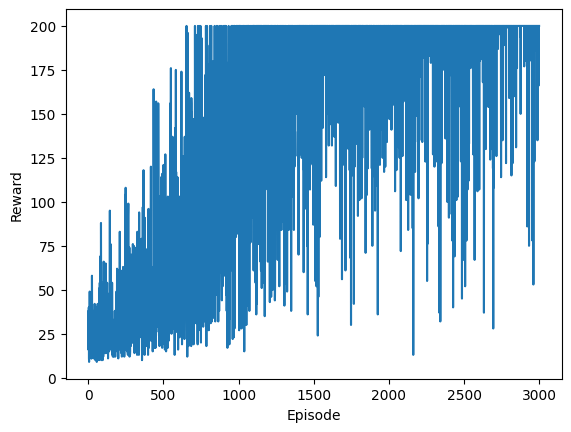

In [ ]:
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
frames = []
state = env.reset()
done = False
total_reward = 0
env.render()
screen = env.render(mode='rgb_array')
frames.append(screen)

while not done:
  action, prob = agent.get_action(state) #
  next_state, reward, done, info = env.step(action) #
  agent.add(reward, prob)
  state = next_state
  total_reward += reward
  env.render() #
  screen = env.render(mode='rgb_array')
  frames.append(screen)

env.close()
print('Total Reward:', total_reward)

/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Reward: 200.0


In [ ]:
# 結果の確認
plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())

NameError: name 'plt' is not defined

In [11]:
class PolicyNet(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x), dim=1)
        return x


class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0002
        self.lr_v = 0.0005
        self.action_size = 2

        self.pi = PolicyNet(self.action_size)
        self.v = ValueNet()

        self.optimizer_pi = optim.Adam(self.pi.parameters(), lr=self.lr_pi)
        self.optimizer_v = optim.Adam(self.v.parameters(), lr=self.lr_v)

    def get_action(self, state):
        state = torch.tensor(state[np.newaxis, :])
        probs = self.pi(state)
        probs = probs[0]
        m = Categorical(probs)
        action = m.sample().item()
        return action, probs[action]

    def update(self, state, action_prob, reward, next_state, done):
        state = torch.tensor(state[np.newaxis, :])
        next_state = torch.tensor(next_state[np.newaxis, :])

        target = reward + self.gamma * self.v(next_state) * (1 - done)
        target.detach()
        v = self.v(state)
        loss_fn = nn.MSELoss()
        loss_v = loss_fn(v, target)

        delta = target - v
        loss_pi = -torch.log(action_prob) * delta.item()

        self.optimizer_v.zero_grad()
        self.optimizer_pi.zero_grad()
        loss_v.backward()
        loss_pi.backward()
        self.optimizer_v.step()
        self.optimizer_pi.step()


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


episode :0, total reward : 48.0
episode :100, total reward : 54.0
episode :200, total reward : 86.0
episode :300, total reward : 89.0
episode :400, total reward : 41.0
episode :500, total reward : 200.0
episode :600, total reward : 168.0
episode :700, total reward : 200.0
episode :800, total reward : 117.0
episode :900, total reward : 177.0
episode :1000, total reward : 200.0
episode :1100, total reward : 200.0
episode :1200, total reward : 134.0
episode :1300, total reward : 200.0
episode :1400, total reward : 146.0
episode :1500, total reward : 168.0
episode :1600, total reward : 200.0
episode :1700, total reward : 163.0
episode :1800, total reward : 200.0
episode :1900, total reward : 200.0


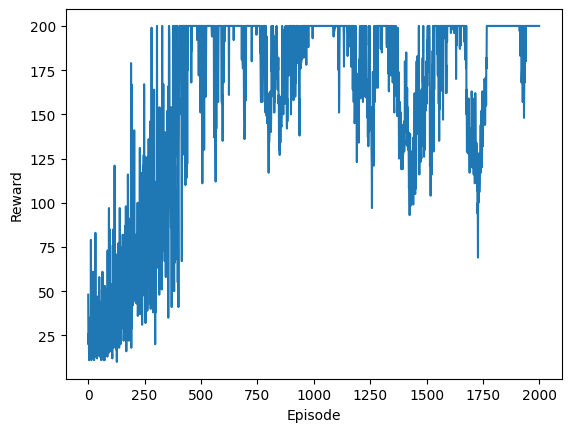

In [12]:
env = gym.make('CartPole-v0')
agent = Agent()
reward_history = []

for episode in range(2000):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.update(state, prob, reward, next_state, done)

        state = next_state
        total_reward += reward

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Reward: 200.0


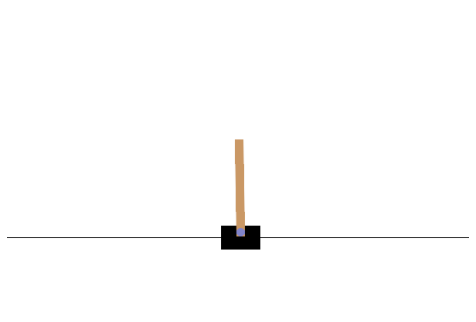

In [13]:
frames = []
state = env.reset()
done = False
total_reward = 0
env.render()
screen = env.render(mode='rgb_array')
frames.append(screen)

while not done:
  action, prob = agent.get_action(state) #
  next_state, reward, done, info = env.step(action) #

  state = next_state
  total_reward += reward
  env.render() #
  screen = env.render(mode='rgb_array')
  frames.append(screen)

env.close()
print('Total Reward:', total_reward)

# 結果の確認
plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())